In [1]:
import sys
print(sys.version)

2.7.13 |Anaconda custom (x86_64)| (default, Dec 20 2016, 23:05:08) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii

import halotools


# COSMOS SMF

Deep sample (not the UD sample) because we need the full COSMOS area to get a signal.

Catalog: http://iopscience.iop.org/article/10.3847/0067-0049/224/2/24/pdf

Cuts: 
- Mass below 10^9
- z between z=0.1 and z=0.4

Some numbers regarding our sample:
- Number of dwarfs :        6876
- Mean mass :      8.52695
- Mean Redshift :     0.301442
- N objects with specz :        1153
- fraction :    0.167685

In [3]:
#first quick&dirty SMF in COSMOS at z~0.2
cosmos_SMF_fit_file='Data/mf_mass2b_fl5b_tot_VmaxFit2D0.dat'
cosmos_SMF_points_file='Data/mf_mass2b_fl5b_tot_Vmax0.dat'

In [4]:
#final SMF in COSMOS at z~0.2
cosmos_SMF_fit_file='Data/cosmos2015_dic2017_smf_z01-04_STY0.dat'
cosmos_SMF_points_file='Data/cosmos2015_dic2017_smf_z01-04_Vmax0.dat'
cosmos_SMF_fit_table=ascii.read(cosmos_SMF_fit_file)
cosmos_SMF_points_table=ascii.read(cosmos_SMF_points_file)


print(cosmos_SMF_fit_table)
print(cosmos_SMF_points_table)

  log_m      log_phi   log_phi_inf log_phi_sup
---------- ----------- ----------- -----------
       0.0   0.9907256   1.0965684   0.8843038
       0.1   0.9593335   1.0640014   0.8540923
       0.2   0.9279413   1.0314345   0.8238808
       0.3   0.8965492   0.9988675   0.7936693
       0.4    0.865157   0.9663005   0.7634578
       0.5   0.8337649   0.9337335   0.7332463
       0.6   0.8023727   0.9011666   0.7030348
       0.7   0.7709806   0.8685996   0.6728233
       0.8   0.7395884   0.8360326   0.6426118
       0.9   0.7081963   0.8034657   0.6124003
       ...         ...         ...         ...
28.9000004 999.9000244 999.9000244 999.9000244
29.0000004 999.9000244 999.9000244 999.9000244
29.1000004 999.9000244 999.9000244 999.9000244
29.2000004 999.9000244 999.9000244 999.9000244
29.3000004 999.9000244 999.9000244 999.9000244
29.4000004 999.9000244 999.9000244 999.9000244
29.5000004 999.9000244 999.9000244 999.9000244
29.6000004 999.9000244 999.9000244 999.9000244
29.7000004 99

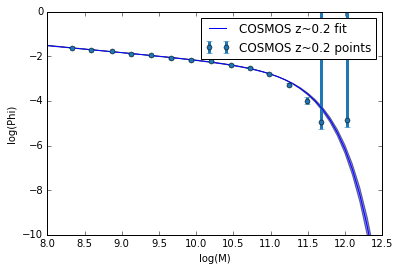

In [5]:
plt.plot(cosmos_SMF_fit_table['log_m'], cosmos_SMF_fit_table['log_phi'], label='COSMOS z~0.2 fit')
plt.fill_between(cosmos_SMF_fit_table['log_m'], cosmos_SMF_fit_table['log_phi_inf'], 
                 cosmos_SMF_fit_table['log_phi_sup'], alpha=0.5)
plt.errorbar(cosmos_SMF_points_table['col1'], cosmos_SMF_points_table['col2'], 
             yerr=[cosmos_SMF_points_table['col3'],cosmos_SMF_points_table['col4']], fmt='o', elinewidth=3,
            markersize=5, c='#1f77b4', label='COSMOS z~0.2 points')

plt.xlabel('log(M)')
plt.ylabel('log(Phi)')
plt.xlim([8,12.5])
plt.ylim([-10,0])
plt.legend()
plt.show()

# Abundance Matching with variable scatter

Pick a set of parameter for the PB model and do abundance matching wth variable scatter, and compare the COSMS SMF with the model SMF.


## read in halo catalog

In [2]:
#halotools catalog

halo_cat_file='Data/hlist_0.78209.list'
#scale(0) id(1) desc_scale(2) desc_id(3) num_prog(4) pid(5) upid(6) desc_pid(7) phantom(8) sam_mvir(9) mvir(10)
#rvir(11) rs(12) vrms(13) mmp?(14) scale_of_last_MM(15) vmax(16) x(17) y(18) z(19) vx(20) vy(21) vz(22) Jx(23) Jy(24) 
#Jz(25) Spin(26) Breadth_first_ID(27) Depth_first_ID(28) Tree_root_ID(29) Orig_halo_ID(30) Snap_num(31) 
#Next_coprogenitor_depthfirst_ID(32) Last_progenitor_depthfirst_ID(33) Last_mainleaf_depthfirst_ID(34) Tidal_Force(35)
#Tidal_ID(36) Rs_Klypin(37) Mvir_all(38) M200b(39) M200c(40) M500c(41) M2500c(42) Xoff(43) Voff(44) Spin_Bullock(45) 
#b_to_a(46) c_to_a(47) A[x](48) A[y](49) A[z](50) b_to_a(500c)(51) c_to_a(500c)(52) A[x](500c)(53) A[y](500c)(54) 
#A[z](500c)(55) T/|U|(56) M_pe_Behroozi(57) M_pe_Diemer(58) Macc(59) Mpeak(60) Vacc(61) Vpeak(62) Halfmass_Scale(63) 
#Acc_Rate_Inst(64) Acc_Rate_100Myr(65) Acc_Rate_1*Tdyn(66) Acc_Rate_2*Tdyn(67) Acc_Rate_Mpeak(68) Mpeak_Scale(69) 
#Acc_Scale(70) First_Acc_Scale(71) First_Acc_Mvir(72) First_Acc_Vmax(73) Vmax@Mpeak(74) Tidal_Force_Tdyn(75) 
#Log_(Vmax/Vmax_Tdyn)(76)


In [3]:
from halotools.sim_manager import TabularAsciiReader
from halotools.sim_manager.rockstar_hlist_reader import RockstarHlistReader
#python 3 gives error about converting unicode 'TypeError: No conversion path for dtype: dtype('<U12')'

output_fname = 'Data/hlist_0.78209.hdf5'
columns_to_keep_dict = {'halo_id': (1, 'i8'), 'halo_upid': (6, 'i8'), 'halo_mvir': (10, 'f4'), 'halo_x': (17, 'f4'), 
                        'halo_y': (18, 'f4'), 'halo_z': (19, 'f4'),'halo_vx': (20, 'f4'), 'halo_vy': (21, 'f4'), 
                        'halo_vz': (22, 'f4'), 'halo_rvir': (11, 'f4'), 'halo_mpeak': (60, 'f4')}

#is there a way to read in all columns? NO

simname = 'bolshoi-planck'
halo_finder = 'rockstar'
version_name = 'bplanck_dwarfs'
ptcl_version_name='bplanck_dwarfs_downsampled2'
ptcl_version_name='bplanck_dwarfs'

redshift = 0.278625 #(1/0.78209)-1 ; a=0.78209
Lbox, particle_mass = 250, 1.5e8

## Read in local file as halo catalog

In [81]:
reader = RockstarHlistReader(halo_cat_file, columns_to_keep_dict, output_fname, simname, halo_finder, redshift, 
                             version_name, Lbox, particle_mass, overwrite=True) # doctest: +SKIP
reader.read_halocat(['halo_rvir'], write_to_disk = True, update_cache_log = True) # doctest: +SKIP



The information about your ascii file and the metadata about the catalog 
have been processed and no exceptions were raised. 
Use the ``read_halocat`` method to read the ascii data, 
setting the write_to_disk and update_cache_log arguments as you like. 
See the docstring of the ``read_halocat`` method
for details about these options. 


...Processing ASCII data of file: 
/Users/fardila/Documents/GitHub/dwarf_lensing/Data/hlist_0.78209.list
 
Total number of rows in detected data = 12939617
Number of rows in detected header = 62 

... working on chunk 0 of 18
... working on chunk 1 of 18
... working on chunk 2 of 18
... working on chunk 3 of 18
... working on chunk 4 of 18
... working on chunk 5 of 18
... working on chunk 6 of 18
... working on chunk 7 of 18
... working on chunk 8 of 18
... working on chunk 9 of 18
... working on chunk 10 of 18
... working on chunk 11 of 18
... working on chunk 12 of 18
... working on chunk 13 of 18
... working on chunk 14 of 18
... working on chunk 1

In [80]:
#explore with h5py
import h5py
# Load file
f = h5py.File('Data/hlist_0.78209.hdf5', 'r')

#HDF files have attributes: metadata attached to the whole dataset
print('Attribute keys : ', f.attrs.keys())
#Then there is the actual data, which is also called with keywords 
print('Dataset keys : ', f.keys())

f['data'].value


('Attribute keys : ', [u'simname', u'halo_finder', u'redshift', u'version_name', u'fname', u'Lbox', u'particle_mass', u'orig_ascii_fname', u'time_of_catalog_production', u'processing_notes'])
('Dataset keys : ', [u'data'])


array([ (-1, 162700004950016.0, 1.2072010040283203, 43.11970138549805, 18.14896011352539, 162700004950016.0, 2404371171, 36.04457092285156, 2404371171),
       (2404371171, 6818999808.0, 0.03770900145173073, 43.78070831298828, 18.667800903320312, 4959000064.0, 2404371172, 35.53276062011719, 2404371171),
       (2404371171, 5888999936.0, 0.035186998546123505, 43.79096984863281, 17.89661979675293, 4028999936.0, 2404371173, 35.40476989746094, 2404371171),
       ...,
       (-1, 309900000.0, 0.014965000562369823, 223.76075744628906, 248.99447631835938, 309900000.0, 2416007927, 237.99644470214844, 2416007927),
       (-1, 464900000.0, 0.01712999865412712, 221.73890686035156, 248.03411865234375, 464900000.0, 2416007949, 225.24017333984375, 2416007949),
       (-1, 2324000000.0, 0.02929299883544445, 225.42611694335938, 243.03797912597656, 2324000000.0, 2416008057, 225.692138671875, 2416008057)], 
      dtype=[('halo_upid', '<i8'), ('halo_mpeak', '<f4'), ('halo_rvir', '<f4'), ('halo_y', '<f4'

In [4]:
#The halo catalog is now stored in cache and can be loaded into memory at any time
from halotools.sim_manager import HaloTableCache, CachedHaloCatalog
cache = HaloTableCache()

#list cache entries
for entry in cache.log: 
    print(entry) 
    
#read in halocat    
halocat = CachedHaloCatalog(simname = simname, halo_finder = halo_finder, 
                            version_name = version_name, redshift = redshift, ptcl_version_name=ptcl_version_name) # doctest: +SKIP

print(halocat.redshift) # doctest: +SKIP
print(halocat.ptcl_version_name) # doctest: +SKIP

       

('bolplanck', 'rockstar', 'halotools_v0p4', '0.4966', '/Users/fardila/.astropy/cache/halotools/halo_catalogs/bolplanck/rockstar/hlist_0.66818.list.halotools_v0p4.hdf5')
('bolshoi', 'rockstar', 'halotools_v0p4', '-0.0003', '/Users/fardila/.astropy/cache/halotools/halo_catalogs/bolshoi/rockstar/hlist_1.00035.list.halotools_v0p4.hdf5')
('bolshoi-planck', 'rockstar', 'bplanck_dwarfs', '0.2786', 'Data/hlist_0.78209.hdf5')
0.2786
bplanck_dwarfs


## abundance match with variable scatter

In [5]:
from halotools.empirical_models import PrebuiltSubhaloModelFactory
model = PrebuiltSubhaloModelFactory('behroozi10', redshift=redshift, 
                                    scatter_abscissa=[12, 15], scatter_ordinates=[0.4, 0.2])
model.populate_mock(halocat)
print(model.mock.galaxy_table[0:9])

halo_upid  halo_hostid halo_mpeak  halo_x ...    vz    galid stellar_mass
---------- ----------- ---------- ------- ... -------- ----- ------------
        -1  2404371171  1.627e+14 36.0446 ...  -118.07     0  1.32292e+11
2404371171  2404371171  6.819e+09 35.5328 ...   484.04     1  1.49804e+06
2404371171  2404371171  5.889e+09 35.4048 ...  -214.14     2     337990.0
2404371171  2404371171  5.734e+09 35.4013 ...  -795.51     3     121673.0
2404371171  2404371171  3.254e+09 35.2266 ...  -213.05     4      17365.6
2404371171  2404371171  7.376e+10 35.8458 ... -1119.11     5  4.17565e+08
2404371171  2404371171  1.085e+09 35.4068 ...  -633.85     6      2929.06
2404371171  2404371171  4.959e+09  36.277 ...  1374.05     7      93461.6
2404371171  2404371171  9.298e+08  35.363 ...  -591.06     8      115.598


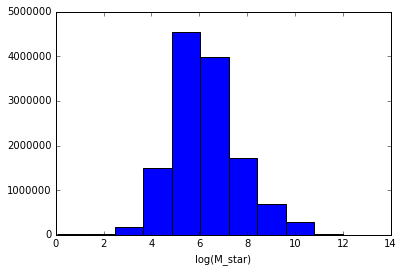

In [28]:
plt.hist(np.log10(model.mock.galaxy_table['stellar_mass']))
plt.xlabel('log(M_star)')
plt.show()

In [10]:
model.param_dict
#model._haloprop_list

{u'scatter_model_param1': 0.40000000000000002,
 u'scatter_model_param2': 0.20000000000000001,
 u'smhm_beta_0': 0.43,
 u'smhm_beta_a': 0.18,
 u'smhm_delta_0': 0.56,
 u'smhm_delta_a': 0.18,
 u'smhm_gamma_0': 1.54,
 u'smhm_gamma_a': 2.52,
 u'smhm_m0_0': 10.72,
 u'smhm_m0_a': 0.59,
 u'smhm_m1_0': 12.35,
 u'smhm_m1_a': 0.3}

In [11]:
#calculate smf
#Bolshoi volume was 250h^(-1)Mpc on each side http://iopscience.iop.org/article/10.1088/0004-637X/740/2/102/pdf

M     = model.mock.galaxy_table['stellar_mass']         #Read stellar masses
logM  = np.log10(M)                     #Take logarithm
nbins = 100                             #Number of bins to divide data into
V     = (250/0.7)**3                    #Survey volume in Mpc3
Phi,edg = np.histogram(logM,bins=nbins) #Unnormalized histogram and bin edges
dM    = edg[1] - edg[0]                 #Bin size
centers   = edg[0:-1] + dM/2.           #Mass axis
Phi   = Phi / float(V) / dM             #Normalize to volume and bin size
logPhi= np.log10(Phi)


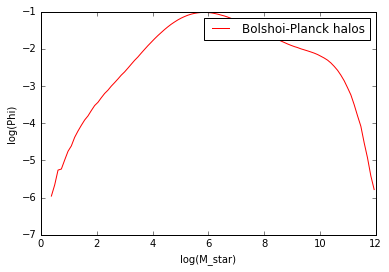

In [26]:
plt.plot(centers,logPhi, c='r', label='Bolshoi-Planck halos')
plt.xlabel('log(M_star)')
plt.ylabel('log(Phi)')
plt.legend()
plt.show()

# plot both SMFs

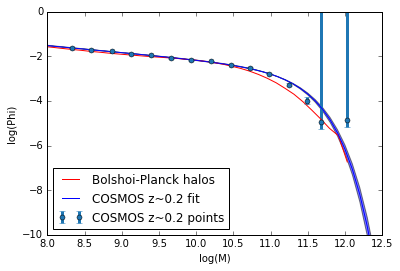

In [14]:
plt.plot(centers,logPhi, c='r', label='Bolshoi-Planck halos')
plt.plot(cosmos_SMF_fit_table['log_m'], cosmos_SMF_fit_table['log_phi'], label='COSMOS z~0.2 fit')
plt.fill_between(cosmos_SMF_fit_table['log_m'], cosmos_SMF_fit_table['log_phi_inf'], 
                 cosmos_SMF_fit_table['log_phi_sup'], alpha=0.5)
plt.errorbar(cosmos_SMF_points_table['col1'], cosmos_SMF_points_table['col2'], 
             yerr=[cosmos_SMF_points_table['col3'],cosmos_SMF_points_table['col4']], fmt='o', elinewidth=3,
            markersize=5, c='#1f77b4', label='COSMOS z~0.2 points')

plt.xlabel('log(M)')
plt.ylabel('log(Phi)')
plt.xlim([8,12.5])
plt.ylim([-10,0])
plt.legend(loc='lower left')
plt.show()

# Compute the lensing

* Read in the DM particles, x, y,z (manually)
* Precompute the lensing
* Then compute the lensing for the model above (plot the model Delta Sigma verus R)
* Then compare the lensing with the data

## read in DM particle positions

In [78]:
px = model.mock.ptcl_table['x']
py = model.mock.ptcl_table['y']
pz = model.mock.ptcl_table['z']
particles = np.vstack((px, py, pz)).T

AttributeError: 'SubhaloMockFactory' object has no attribute 'ptcl_table'

In [6]:
from astropy.table import Table

ptcl_table = Table.read('Data/bplanck_particles_100m_a0.78209.hdf5', path='data')

px = ptcl_table['x']
py = ptcl_table['y']
pz = ptcl_table['z']
particles = np.vstack((px, py, pz)).T

## read in galaxy positions

In [7]:
x = model.mock.galaxy_table['x']
y = model.mock.galaxy_table['y']
z = model.mock.galaxy_table['z']
galaxies = np.vstack((x, y, z)).T

In [8]:
print len(galaxies)
print len(particles)

12939617
99993334


### Make cut in mass

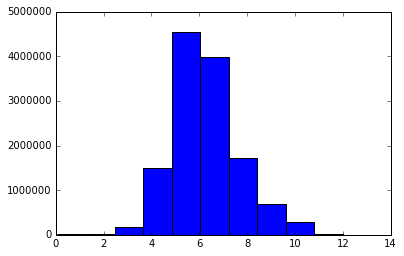

In [33]:
plt.hist(np.log10(model.mock.galaxy_table['stellar_mass']))
plt.show()


In [11]:
galaxies_table=model.mock.galaxy_table[np.log10(model.mock.galaxy_table['stellar_mass'])>10]

In [12]:
len(galaxies_table)

170063

### read in again with mass cut

In [13]:
x = galaxies_table['x']
y = galaxies_table['y']
z = galaxies_table['z']
galaxies = np.vstack((x, y, z)).T

## precompute lensing


### downsample

In [14]:
from halotools.utils import randomly_downsample_data
num_ptcls_to_use = int(1e4)
particles = randomly_downsample_data(particles, num_ptcls_to_use)
particle_masses = np.zeros(num_ptcls_to_use) + halocat.particle_mass

#need to account for the fact that you are not using the entire snapshot of particles by providing the downsampling_factor argument:
halocat.num_ptcl_per_dim=2048 #for bolshoi-planck : https://github.com/astropy/halotools/blob/master/halotools/sim_manager/supported_sims.py
total_num_ptcl_in_snapshot = halocat.num_ptcl_per_dim**3
downsampling_factor = total_num_ptcl_in_snapshot/float(len(particles))

rp_bins = np.logspace(-1, 1, 10)
period = model.mock.Lbox    
    

### calculate the mass enclosed by the cylinders around each galaxy

In [15]:
from halotools.mock_observables import total_mass_enclosed_per_cylinder

mass_encl = total_mass_enclosed_per_cylinder(galaxies, particles, particle_masses, downsampling_factor, rp_bins, period)

#create mask for centrals
# cenmask = model.mock.galaxy_table['gal_type'] == 'centrals'
# cens = galaxies[cenmask]
# mass_encl_cens = mass_encl[cenmask, :]


In [16]:
#cosmology
from astropy.cosmology import LambdaCDM
H0=67.8
Om0=0.307
Ode0=0.693

halocat.cosmology = LambdaCDM(H0, Om0, Ode0)

### delta sigma

In [17]:
from halotools.mock_observables import delta_sigma_from_precomputed_pairs
rp, ds = delta_sigma_from_precomputed_pairs(galaxies, mass_encl, rp_bins, period, cosmology=halocat.cosmology)
ds = ds/1e12 #there seems to be a discrepancy in units pc^2 --> Mpc^2

## plot

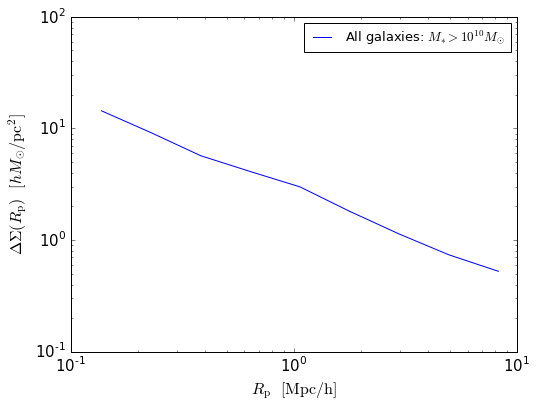

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

__=plt.loglog()

__=ax.plot(rp, ds, label=r'All galaxies: $M_{\ast} > 10^{10}M_{\odot}$')
# __=ax.plot(rp, result_mstar105_satellite_in_pc, label=r'Satellites: $M_{\ast} \approx 10^{10.5}M_{\odot}$')
# __=ax.plot(rp, result_mstar105_in_pc, label=r'All galaxies: $M_{\ast} \approx 10^{10.5}M_{\odot}$')
# __=ax.plot(rp, result_mstar105_central_in_pc, label=r'Centrals: $M_{\ast} \approx 10^{10.5}M_{\odot}$')

__=ax.set_xlim(xmin = 0.1, xmax = 10)
# __=ax.set_ylim(ymin = 0.5, ymax = 200)

__=ax.set_xlabel(r'$R_{\rm p} $  $\rm{[Mpc / h]}$', fontsize=16)
__=ax.set_ylabel(r'$\Delta\Sigma(R_{\rm p})$  $[h M_{\odot} / {\rm pc}^2]$', fontsize=16)
__=ax.legend(loc='best', fontsize=13)
__=plt.xticks(fontsize=15); plt.yticks(fontsize=15)


plt.show()

## compare with data

Will get distribution of masses from data (COSMOS dwarf galaxies) and match that distribution in simulation galaxies, then use that catalog to calculate lensing signal. Then use MCMC to match lensing signal to measured lensing signal of dwarf galaxies.